In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
from scipy.stats import norm
import tensorflow.compat.v1 as tf
import time as ttt
import os
import pprint

import tensorflow.compat.v1.keras.backend as K
from tensorflow.compat.v1.keras.backend import set_session
from tensorflow.compat.v1.keras.models import Sequential
from tensorflow.compat.v1.keras.layers import Dense, Activation,LSTM
from tensorflow.compat.v1.keras.optimizers import Adam
from tensorflow.compat.v1.keras.regularizers import L1L2

tf.disable_v2_behavior()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  
config.log_device_placement = True 

def generate_t(T, steps, M):
    '''
    time discretization (M * (steps+1 +1)) 
    for computing the time derivative, we need an extra time step.
    '''
    t_temp = np.linspace(1e-6, T- 1e-6, steps +1, dtype = np.float32)
    return np.tile(np.concatenate((t_temp, [T + dt])), (M,1)) 

def Create_paths(i, M, z, T, sigma, x_0):
    '''
    GBM paths (M * (steps+1)) with seed i
    number of steps could be 100, 200, 500, 1000.
    '''
    
    # generate time steps for each path
    mu = z / T
    np.random.seed(i)
    x = np.tile(x_0, (M, 1))
    path = np.tile(x_0, (M, 1))
    delta = T / 200
    
    dW = np.sqrt(delta)*np.random.normal(size=(M, 200))
    for k in range(200):
        x += mu * x * delta + sigma * x * dW[:,k:k+1]
        path = np.concatenate((path, x), axis = 1)
        
    #  select # of steps (100, 200, 500, 1000) from total 1000 timesteps
    selection = np.linspace(0,200, steps+1, dtype = np.int) 
    path = np.array(path, dtype=np.float32)
    path_selection = path[:,selection]

    return np.array(path_selection, dtype=np.float32)



Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

PDE_coeff = pd.read_csv('/content/drive/MyDrive/PDE_coefficients.csv')
A = PDE_coeff['A'].to_numpy()
B = PDE_coeff['B'].to_numpy()
policy_mean = np.load('/content/drive/MyDrive/policy_mean_coeff.npy')
policy_variance = np.load('/content/drive/MyDrive/policy_var_coeff.npy')
df = pd.read_csv('/content/drive/MyDrive/25_stocks_2020_2022.csv')
stock_prices = df.iloc[:, 2:].to_numpy() 
stock_prices = stock_prices[61:]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
np.sum(policy_mean[0])


0.010023823345287737

In [ ]:
M = 128
x_0 = 1.0
Epoch = 101
periods = 28

In [ ]:
n_a = 128
LSTM_cell = LSTM(n_a, return_state = True) 

NN = Sequential([
      Dense(128, input_shape=(1+1+n_a,)),
      Activation('tanh'),
      Dense(128),
      Activation('tanh'),
      Dense(128),
      Activation('tanh'),
      Dense(1)
  ])

  #define the loss function again, just in case
def loss_function(time,path, M, A, B):
    
    a = tf.Variable(tf.zeros([M, n_a]), trainable=False)
    c = tf.Variable(tf.zeros([M, n_a]), trainable=False)

##. Approximate f(X_{t_0})
    input_x = tf.slice(path, [0,0], [M,1])
    input_t = tf.slice(time, [0,0], [M,1])
    inputt_f = K.concatenate([input_x, input_t, a])
    f = NN(inputt_f)
                      
##.   calculate space derivatives
    bump = 0.01 * input_x
    input_x_up = input_x + bump
    inputt_up = K.concatenate([input_x_up, input_t, a])
    f_up = NN(inputt_up)
    input_x_down = input_x - bump
    inputt_down = K.concatenate([input_x_down, input_t, a])
    f_down = NN(inputt_down)
    partial_x_f = tf.math.abs((f_up - f)/bump)
    partial_xx_f = tf.math.abs((f_up - 2 * f + f_down)/bump/bump)

##. Next LSTM cell
    input_x_reshape = tf.reshape(input_x, (M,1,1))
    input_t_reshape = tf.reshape(input_t, (M,1,1))
    inputt = K.concatenate([input_x_reshape, input_t_reshape])
    a, _, c = LSTM_cell(inputt, initial_state = [a, c])
    
##.   calculate time derivative
    input_t_time = tf.slice(time, [0, 1], [M, 1])
    inputt_time = K.concatenate([input_x, input_t_time, a])
    f_flat = NN(inputt_time)
    partial_t_f = (f_flat - f)/dt
    
    Loss = tf.reduce_sum(tf.square(partial_t_f * partial_xx_f - A * tf.square(partial_x_f) + B * partial_xx_f))

    solution = f
    time_derivative = partial_t_f 
    space_derivative = partial_x_f
    space_2nd_derivative = partial_xx_f
    

    #############################################################################
    for i in range(1, steps+1): # Iterate through every timestep
        
        ##. Approximate f(X_{t_i})
        input_x = tf.slice(path, [0,i], [M,1])
        input_t = tf.slice(time, [0,i], [M,1])
        inputt_f = K.concatenate([input_x, input_t, a])
        f = NN(inputt_f)
        
        ##. calculate space derivative
        bump = 0.01 * input_x
        input_x_up = input_x + bump
        inputt_up = K.concatenate([input_x_up, input_t, a])
        f_up = NN(inputt_up)
        input_x_down = input_x - bump
        inputt_down = K.concatenate([input_x_down, input_t, a])
        f_down = NN(inputt_down)
        partial_x_f = tf.math.abs((f_up - f)/bump)
        partial_xx_f = tf.math.abs((f_up - 2*f + f_down)/bump/bump)
    
        ##. Next LSTM cell
        input_x_reshape = tf.reshape(input_x, (M,1,1))
        input_t_reshape = tf.reshape(input_t, (M,1,1))
        inputt = K.concatenate([input_x_reshape, input_t_reshape])
        a, _, c = LSTM_cell(inputt, initial_state = [a, c])

        ##. calculate time derivative
        input_t_time = tf.slice(time, [0, i+1], [M, 1])
        inputt_time = K.concatenate([input_x, input_t_time, a])
        f_flat = NN(inputt_time)
        partial_t_f = (f_flat - f)/dt
        
        Loss += tf.reduce_sum(tf.square(partial_t_f * partial_xx_f - A * tf.square(partial_x_f) + B * partial_xx_f))


        solution = K.concatenate([solution, f]) 
        time_derivative = K.concatenate([time_derivative, partial_t_f]) 
        space_derivative = K.concatenate([space_derivative, partial_x_f])
        space_2nd_derivative = K.concatenate([space_2nd_derivative, partial_xx_f])

    #############################################################################
    #terminal condition with fixed w = 1.2

    Loss += tf.reduce_sum( tf.square(f - tf.square(path[:, -1] - z + 1)))*steps

    return Loss/M/steps, solution, time_derivative, space_derivative, space_2nd_derivative

In [ ]:
x = np.array([1.0, 1.01])

2
this is the length of x
0.0050000000000000044
0.0


<ipython-input-1-bfa14b1f8875>:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  selection = np.linspace(0,200, steps+1, dtype = np.int)


1th Epoch:
traing loss is 1410.7210693359375, test loss is 1410.7210693359375, and learning rate is 0.009999999776482582, elapsed is 1.8573863506317139.
 


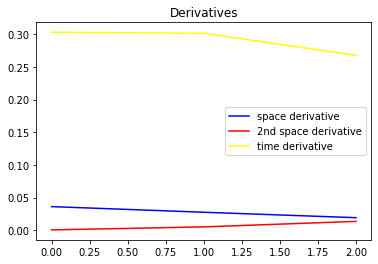

11th Epoch:
traing loss is 11.386900901794434, test loss is 11.386900901794434, and learning rate is 0.009999999776482582, elapsed is 0.6291580200195312.
 
21th Epoch:
traing loss is 0.08567312359809875, test loss is 0.08567312359809875, and learning rate is 0.009999999776482582, elapsed is 0.13364720344543457.
 
31th Epoch:
traing loss is 0.23891885578632355, test loss is 0.23891885578632355, and learning rate is 0.009999999776482582, elapsed is 0.13538622856140137.
 
41th Epoch:
traing loss is 0.3752235174179077, test loss is 0.3752235174179077, and learning rate is 0.009999999776482582, elapsed is 0.13573098182678223.
 
51th Epoch:
traing loss is 0.41360709071159363, test loss is 0.41360709071159363, and learning rate is 0.009999999776482582, elapsed is 0.13913202285766602.
 
61th Epoch:
traing loss is 0.02145007625222206, test loss is 0.02145007625222206, and learning rate is 0.009999999776482582, elapsed is 0.1337883472442627.
 
71th Epoch:
traing loss is 0.27242714166641235, test

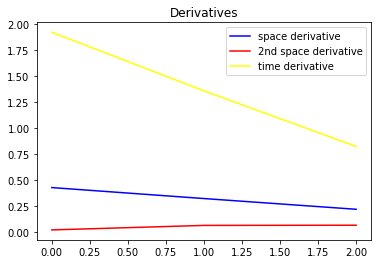

the space_derivative is 0.21901461482048035, the space_2nd_derivative is 0.06544182449579239
the policy_mean_tmp is [-0.44052948 -0.00463156 -0.32225    -0.02496807  0.255332    0.28993731
  0.03038662  0.14781813 -0.13940362 -0.10411636 -0.19074397 -0.017168
  0.26361911  0.16927543 -0.35816667  0.26074397  0.19535252 -0.19486229
  0.27169581  0.29031134 -0.22125261 -0.01077353 -0.24705884 -0.4467604
 -0.01619989], 
 the policy_var_tmp is [[ 6.57113447e-02  8.39326421e-03 -5.38948929e-03 -5.91313514e-03
   6.96132118e-04 -9.16260735e-03 -4.81361006e-03 -4.79984801e-03
  -1.88680801e-02 -6.04952443e-03  6.16248978e-03 -4.99836043e-03
   2.84206370e-03 -8.93769901e-03  1.10954251e-02 -4.13029998e-03
  -1.47609661e-02  1.61151137e-02 -7.54049819e-03 -1.96725076e-03
  -1.03626111e-02  2.10652410e-03  4.63278109e-03  8.82796732e-03
   2.06477300e-03]
 [ 8.39326421e-03  2.73108544e-02  3.01957256e-03 -5.79377881e-03
  -5.81074600e-03 -1.66358039e-03 -4.36167220e-04 -3.58559044e-04
  -6.1837

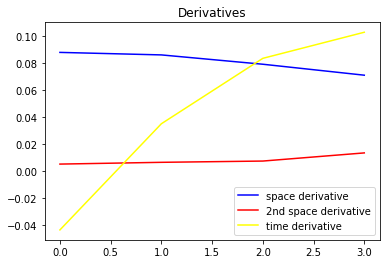

11th Epoch:
traing loss is 20.693681716918945, test loss is 20.696704864501953, and learning rate is 0.009999999776482582, elapsed is 0.6984636783599854.
 
21th Epoch:
traing loss is 12.540153503417969, test loss is 12.54590129852295, and learning rate is 0.009999999776482582, elapsed is 0.16038274765014648.
 
31th Epoch:
traing loss is 0.5360344648361206, test loss is 0.5374558568000793, and learning rate is 0.009999999776482582, elapsed is 0.18524599075317383.
 
41th Epoch:
traing loss is 0.034178171306848526, test loss is 0.03438477963209152, and learning rate is 0.009999999776482582, elapsed is 0.2527587413787842.
 
51th Epoch:
traing loss is 5.0004425048828125, test loss is 5.017326354980469, and learning rate is 0.009999999776482582, elapsed is 0.2529776096343994.
 
61th Epoch:
traing loss is 0.13363410532474518, test loss is 0.13405656814575195, and learning rate is 0.009999999776482582, elapsed is 0.23414874076843262.
 
71th Epoch:
traing loss is 4.3203277587890625, test loss i

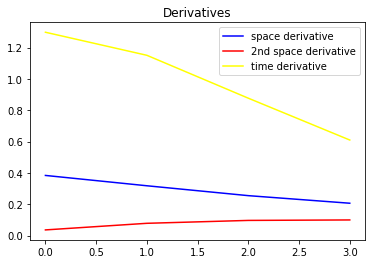

the space_derivative is 0.20621569454669952, the space_2nd_derivative is 0.09695969521999359
the policy_mean_tmp is [-0.27660004  0.06889909 -0.3207306  -0.03153227  0.20960947  0.08514694
  0.11180946 -0.0311773  -0.16067727 -0.04957823 -0.14012587  0.04039915
  0.22663233  0.26525854 -0.31926699  0.22846316  0.16849614 -0.18350382
  0.17242521  0.20519443 -0.23908387  0.06773606 -0.18070158 -0.31054503
  0.08044619], 
 the policy_var_tmp is [[ 4.43315121e-02  5.81972012e-03 -3.74100778e-03 -4.13442552e-03
   4.46879878e-04 -6.45255229e-03 -3.00392215e-03 -3.54531684e-03
  -1.27937724e-02 -3.96934281e-03  4.14391146e-03 -3.28356829e-03
   2.10762924e-03 -6.09505695e-03  7.34736841e-03 -2.85296618e-03
  -9.90136166e-03  1.09405190e-02 -5.12962270e-03 -1.37528819e-03
  -7.11100944e-03  1.67913540e-03  3.18832779e-03  6.03013609e-03
   1.56907072e-03]
 [ 5.81972012e-03  1.88789441e-02  5.87693753e-04 -3.45997578e-03
  -3.00400857e-03 -1.46398335e-03  5.14755268e-05 -8.37820703e-04
  -5.1

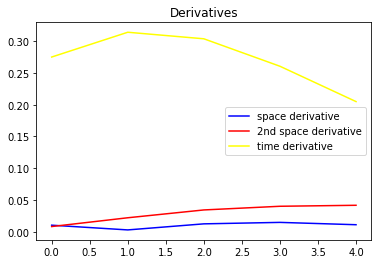

11th Epoch:
traing loss is 24.440038681030273, test loss is 24.437498092651367, and learning rate is 0.009999999776482582, elapsed is 0.850987434387207.
 
21th Epoch:
traing loss is 7.559952735900879, test loss is 7.556507110595703, and learning rate is 0.009999999776482582, elapsed is 0.18062686920166016.
 
31th Epoch:
traing loss is 5.682218551635742, test loss is 5.678310394287109, and learning rate is 0.009999999776482582, elapsed is 0.1985607147216797.
 
41th Epoch:
traing loss is 5.981664180755615, test loss is 5.981560230255127, and learning rate is 0.009999999776482582, elapsed is 0.18100261688232422.
 
51th Epoch:
traing loss is 6.670130252838135, test loss is 6.654287338256836, and learning rate is 0.009999999776482582, elapsed is 0.1787886619567871.
 
61th Epoch:
traing loss is 7.427419662475586, test loss is 7.430817127227783, and learning rate is 0.009999999776482582, elapsed is 0.17686748504638672.
 
71th Epoch:
traing loss is 8.174508094787598, test loss is 8.17158889770

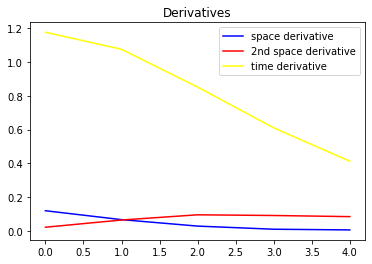

the space_derivative is 0.004892901051789522, the space_2nd_derivative is 0.07874809205532074
the policy_mean_tmp is [-0.00580514  0.00408608 -0.00971882 -0.00379132  0.00492093  0.00295113
  0.0043083  -0.00395705 -0.00620491 -0.00111509 -0.00433797  0.00110753
  0.00615571  0.01142123 -0.01175284  0.0032104   0.00560339 -0.00684177
  0.00635023  0.00642116 -0.00813405  0.00549946 -0.00511318 -0.00615532
  0.00121301], 
 the policy_var_tmp is [[ 5.45788074e-02  7.58419595e-03 -5.23000710e-03 -4.49220986e-03
   1.87644321e-03 -5.02120783e-03 -3.39828829e-03 -6.01152406e-03
  -1.57366848e-02 -4.80675132e-03  4.35835202e-03 -4.48972805e-03
   2.66320614e-03 -2.88061808e-03  6.68658283e-03 -3.56054101e-03
  -1.22988674e-02  1.03353898e-02 -5.84591168e-03 -9.07648268e-04
  -8.80467703e-03  3.13172250e-03  3.24107386e-03  6.26313876e-03
   1.01641331e-03]
 [ 7.58419595e-03  2.39952597e-02  1.14841267e-04 -4.27188295e-03
  -2.76594081e-03  8.32670965e-04  5.18878571e-04 -3.03314977e-03
  -6.

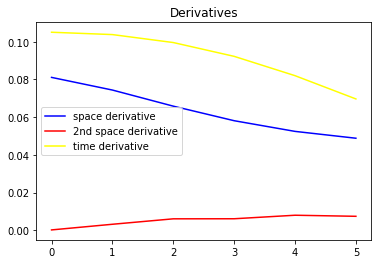

11th Epoch:
traing loss is 2.976602554321289, test loss is 2.9778032302856445, and learning rate is 0.009999999776482582, elapsed is 0.9870939254760742.
 
21th Epoch:
traing loss is 26.7744083404541, test loss is 26.78179931640625, and learning rate is 0.009999999776482582, elapsed is 0.21590805053710938.
 
31th Epoch:
traing loss is 3.2269387245178223, test loss is 3.2299702167510986, and learning rate is 0.009999999776482582, elapsed is 0.20318937301635742.
 
41th Epoch:
traing loss is 0.9121186137199402, test loss is 0.9124568104743958, and learning rate is 0.009999999776482582, elapsed is 0.21965765953063965.
 
51th Epoch:
traing loss is 1.8149241209030151, test loss is 1.8226360082626343, and learning rate is 0.009999999776482582, elapsed is 0.21668004989624023.
 
61th Epoch:
traing loss is 0.008516611531376839, test loss is 0.00845451932400465, and learning rate is 0.009999999776482582, elapsed is 0.2164621353149414.
 
71th Epoch:
traing loss is 0.33175772428512573, test loss is 

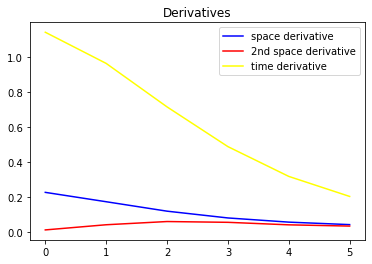

the space_derivative is 0.04270947352051735, the space_2nd_derivative is 0.039339710026979446
the policy_mean_tmp is [-0.08133448  0.08697951 -0.19227229 -0.07419057  0.07196242  0.04092365
  0.09275218 -0.06743645 -0.12845288 -0.05035769 -0.09780319  0.01874993
  0.11373257  0.26230864 -0.18747446  0.00681247  0.08558616 -0.12886319
  0.08383809  0.14814578 -0.16153967  0.1053463  -0.08838668 -0.10072863
  0.04748323], 
 the policy_var_tmp is [[ 1.08566453e-01  1.58211729e-02 -1.10901887e-02 -9.08419153e-03
   3.59840166e-03 -9.81362468e-03 -6.34057225e-03 -1.44176186e-02
  -3.17287791e-02 -9.61451695e-03  8.71032072e-03 -9.11383134e-03
   6.58089442e-03 -3.08029547e-03  1.30761525e-02 -5.84123164e-03
  -2.45410908e-02  2.03021048e-02 -1.08049804e-02 -2.03766715e-03
  -1.83704081e-02  6.07708469e-03  5.44366359e-03  1.29800418e-02
   2.20678016e-03]
 [ 1.58211729e-02  4.90532005e-02 -1.10644040e-03 -8.96677426e-03
  -6.26804402e-03  1.27178982e-03  2.06894849e-03 -7.05926275e-03
  -1.

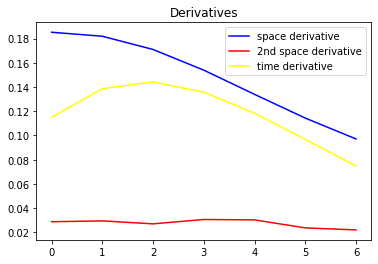

11th Epoch:
traing loss is 40.69059753417969, test loss is 40.69700622558594, and learning rate is 0.009999999776482582, elapsed is 1.3318216800689697.
 
21th Epoch:
traing loss is 17.454132080078125, test loss is 17.455413818359375, and learning rate is 0.009999999776482582, elapsed is 0.3438150882720947.
 
31th Epoch:
traing loss is 12.541529655456543, test loss is 12.541686058044434, and learning rate is 0.009999999776482582, elapsed is 0.3477973937988281.
 
41th Epoch:
traing loss is 10.025842666625977, test loss is 10.030086517333984, and learning rate is 0.009999999776482582, elapsed is 0.352616548538208.
 
51th Epoch:
traing loss is 8.68772029876709, test loss is 8.676493644714355, and learning rate is 0.009999999776482582, elapsed is 0.34130215644836426.
 
61th Epoch:
traing loss is 8.044093132019043, test loss is 8.051078796386719, and learning rate is 0.009999999776482582, elapsed is 0.3559243679046631.
 
71th Epoch:
traing loss is 7.479600429534912, test loss is 7.4810552597

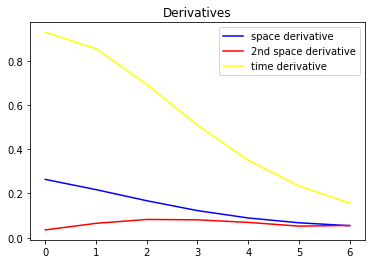

the space_derivative is 0.054273076355457306, the space_2nd_derivative is 0.045285772532224655
the policy_mean_tmp is [-0.08397423  0.09836632 -0.21361537 -0.08347914  0.07238103  0.04411261
  0.10163502 -0.08322308 -0.14145511 -0.05947427 -0.10432388  0.02027746
  0.12051665  0.2779315  -0.20040576  0.01018373  0.08942245 -0.13007494
  0.08853103  0.16709972 -0.18632551  0.1221779  -0.08594258 -0.10520326
  0.04491532], 
 the policy_var_tmp is [[ 9.59885087e-02  1.52004464e-02 -8.59298841e-03 -8.22272852e-03
   1.27366142e-03 -9.22941238e-03 -6.86879808e-03 -1.37196868e-02
  -2.84642278e-02 -9.34730404e-03  8.71096642e-03 -8.32007147e-03
   5.37879778e-03 -5.92182982e-03  1.33197752e-02 -5.69485906e-03
  -2.31886233e-02  2.05568435e-02 -9.34666948e-03 -1.66036650e-03
  -1.72224764e-02  6.78096489e-03  7.68649610e-03  1.34888161e-02
  -3.08153950e-04]
 [ 1.52004464e-02  4.37438607e-02 -3.03641299e-04 -8.09864261e-03
  -7.08569634e-03  5.61362436e-04  8.11850715e-04 -7.40061172e-03
  -1

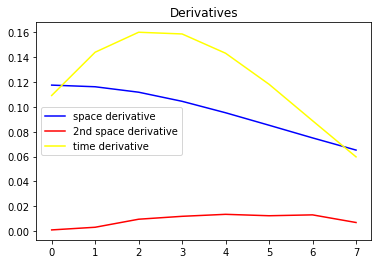

11th Epoch:
traing loss is 56.81995391845703, test loss is 56.8171272277832, and learning rate is 0.009999999776482582, elapsed is 1.4103367328643799.
 
21th Epoch:
traing loss is 0.15767090022563934, test loss is 0.15808720886707306, and learning rate is 0.009999999776482582, elapsed is 0.27910923957824707.
 
31th Epoch:
traing loss is 12.422043800354004, test loss is 12.426922798156738, and learning rate is 0.009999999776482582, elapsed is 0.28526973724365234.
 
41th Epoch:
traing loss is 1.6213222742080688, test loss is 1.6213383674621582, and learning rate is 0.009999999776482582, elapsed is 0.28675246238708496.
 
51th Epoch:
traing loss is 5.117861270904541, test loss is 5.10548734664917, and learning rate is 0.009999999776482582, elapsed is 0.28714489936828613.
 
61th Epoch:
traing loss is 0.3588210344314575, test loss is 0.35953566431999207, and learning rate is 0.009999999776482582, elapsed is 0.27347230911254883.
 
71th Epoch:
traing loss is 1.6034786701202393, test loss is 1.

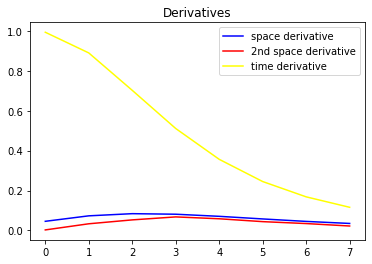

the space_derivative is 0.03528265282511711, the space_2nd_derivative is 0.034960195422172546
the policy_mean_tmp is [-0.0615251   0.09445985 -0.16492216 -0.0766654   0.05924084  0.04128984
  0.08772561 -0.08234895 -0.11980475 -0.05295216 -0.09446893  0.01608013
  0.10530731  0.26303946 -0.18281306  0.00873158  0.0796149  -0.13049383
  0.07131652  0.14062813 -0.157006    0.11186158 -0.08319577 -0.08571469
  0.03050677], 
 the policy_var_tmp is [[ 1.24156607e-01  1.99357065e-02 -6.32112618e-03 -1.06576247e-02
   2.35977450e-03 -1.24739997e-02 -9.17723097e-03 -1.72206978e-02
  -3.58539543e-02 -1.23652888e-02  1.16346952e-02 -1.13436203e-02
   6.88387632e-03 -9.99279665e-03  1.64080558e-02 -7.09713867e-03
  -2.96262417e-02  2.70548052e-02 -1.19335498e-02 -3.23484488e-03
  -2.20371345e-02  8.89821533e-03  8.90734639e-03  1.69932068e-02
  -2.36010081e-03]
 [ 1.99357065e-02  5.74233733e-02  4.81685085e-03 -1.07858122e-02
  -8.58754406e-03  4.26846461e-04  8.85329228e-04 -9.62459579e-03
  -1.

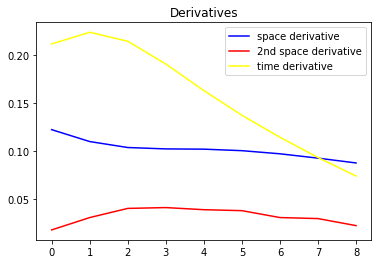

11th Epoch:
traing loss is 50.544464111328125, test loss is 50.548831939697266, and learning rate is 0.009999999776482582, elapsed is 2.3342690467834473.
 
21th Epoch:
traing loss is 0.8708353042602539, test loss is 0.8708295226097107, and learning rate is 0.009999999776482582, elapsed is 0.4034454822540283.
 
31th Epoch:
traing loss is 3.0361669063568115, test loss is 3.0356194972991943, and learning rate is 0.009999999776482582, elapsed is 0.29071497917175293.
 
41th Epoch:
traing loss is 15.822465896606445, test loss is 15.826254844665527, and learning rate is 0.009999999776482582, elapsed is 0.3022956848144531.
 
51th Epoch:
traing loss is 0.09201882779598236, test loss is 0.0932159498333931, and learning rate is 0.009999999776482582, elapsed is 0.2889547348022461.
 
61th Epoch:
traing loss is 4.247657299041748, test loss is 4.243414878845215, and learning rate is 0.009999999776482582, elapsed is 0.2921938896179199.
 
71th Epoch:
traing loss is 0.07188291102647781, test loss is 0.0

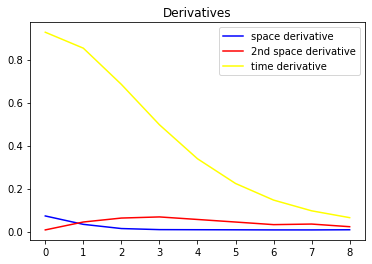

the space_derivative is 0.008301205933094025, the space_2nd_derivative is 0.020002048462629318
the policy_mean_tmp is [-0.02420061  0.04216837 -0.05617464 -0.0232575   0.02053544  0.00878313
  0.0280081  -0.0378866  -0.04440847 -0.02327487 -0.03305286  0.0070335
  0.04119881  0.08490695 -0.07574172 -0.00048749  0.02793966 -0.03059881
  0.02608013  0.05712582 -0.06553133  0.04551877 -0.02744717 -0.03518677
  0.01640931], 
 the policy_var_tmp is [[ 2.34655817e-01  4.09295609e-02 -1.57838615e-02 -2.18746421e-02
  -5.94274581e-03 -2.37288758e-02 -2.16897115e-02 -1.21391210e-02
  -7.48697148e-02 -2.92077229e-02  1.75745974e-02 -2.22438990e-02
   1.79306766e-02 -2.59011647e-02  3.93289222e-02 -1.49387098e-02
  -4.79656475e-02  4.81246858e-02 -2.60397006e-02 -9.25820703e-03
  -5.16984498e-02  1.66958324e-02  2.44728886e-02  2.80833790e-02
  -7.59688766e-03]
 [ 4.09295609e-02  1.02018460e-01  4.97871836e-03 -2.12536873e-02
  -1.79960979e-02  1.30457107e-03  7.67662877e-04 -9.85198732e-03
  -3.

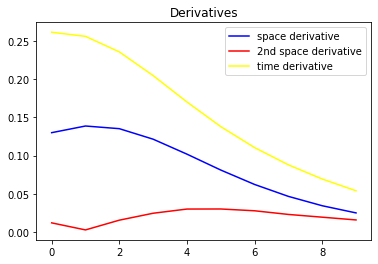

11th Epoch:
traing loss is 5.594481945037842, test loss is 5.5896897315979, and learning rate is 0.009999999776482582, elapsed is 1.8168079853057861.
 
21th Epoch:
traing loss is 10.706729888916016, test loss is 10.702852249145508, and learning rate is 0.009999999776482582, elapsed is 0.4780116081237793.
 
31th Epoch:
traing loss is 0.6543601155281067, test loss is 0.6536511778831482, and learning rate is 0.009999999776482582, elapsed is 0.46383047103881836.
 
41th Epoch:
traing loss is 1.7741053104400635, test loss is 1.770859718322754, and learning rate is 0.009999999776482582, elapsed is 0.45125412940979004.
 
51th Epoch:
traing loss is 6.347487449645996, test loss is 6.357442378997803, and learning rate is 0.009999999776482582, elapsed is 0.46799564361572266.
 
61th Epoch:
traing loss is 0.4717535078525543, test loss is 0.46909502148628235, and learning rate is 0.009999999776482582, elapsed is 0.47237372398376465.
 
71th Epoch:
traing loss is 0.10152539610862732, test loss is 0.101

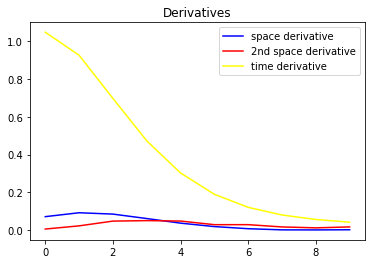

the space_derivative is 0.0021721888333559036, the space_2nd_derivative is 0.01221630908548832
the policy_mean_tmp is [-0.00961009  0.01984579 -0.02332342 -0.00917486  0.01306271  0.00066039
  0.01227854 -0.01550553 -0.02183703 -0.0081546  -0.013788    0.00417371
  0.01938493  0.03216647 -0.03619332 -0.00115452  0.01290283 -0.00556412
  0.01110508  0.01918472 -0.03178521  0.02027582 -0.01075722 -0.01332874
  0.00896371], 
 the policy_var_tmp is [[ 3.84464109e-01  6.81258797e-02 -2.70138695e-02 -3.62682901e-02
  -9.02200796e-03 -3.93970436e-02 -3.53847924e-02 -1.90105837e-02
  -1.23437769e-01 -4.77401083e-02  2.83720050e-02 -3.60815606e-02
   2.98931218e-02 -4.42714161e-02  6.35283229e-02 -2.64337349e-02
  -7.80575955e-02  8.12918039e-02 -4.29566421e-02 -1.62713496e-02
  -8.52244982e-02  2.79738801e-02  4.08054833e-02  4.63790666e-02
  -1.15965542e-02]
 [ 6.81258797e-02  1.69473385e-01  9.71660298e-03 -3.34022870e-02
  -2.29734569e-02 -2.57727709e-03  1.65385996e-03 -1.52732421e-02
  -5

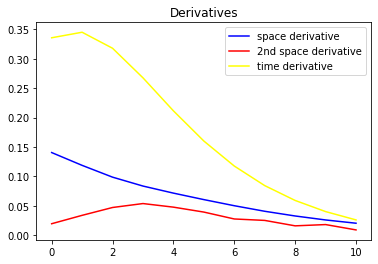

11th Epoch:
traing loss is 23.83633804321289, test loss is 23.853395462036133, and learning rate is 0.009999999776482582, elapsed is 2.516746759414673.
 
21th Epoch:
traing loss is 14.820292472839355, test loss is 14.823099136352539, and learning rate is 0.009999999776482582, elapsed is 0.5061473846435547.
 
31th Epoch:
traing loss is 0.7661496996879578, test loss is 0.7663232684135437, and learning rate is 0.009999999776482582, elapsed is 0.5226647853851318.
 
41th Epoch:
traing loss is 0.09449825435876846, test loss is 0.0931505560874939, and learning rate is 0.009999999776482582, elapsed is 0.5313060283660889.
 
51th Epoch:
traing loss is 0.39447590708732605, test loss is 0.3846505582332611, and learning rate is 0.009999999776482582, elapsed is 0.3826589584350586.
 
61th Epoch:
traing loss is 0.949229896068573, test loss is 0.9397630095481873, and learning rate is 0.009999999776482582, elapsed is 0.35686445236206055.
 
71th Epoch:
traing loss is 0.9051925539970398, test loss is 0.90

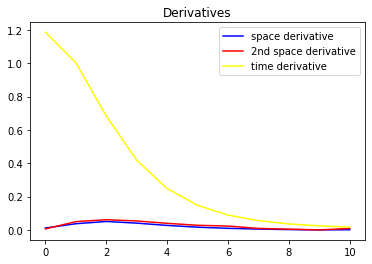

the space_derivative is 0.0012037516571581364, the space_2nd_derivative is 0.004495283123105764
the policy_mean_tmp is [-1.72672703e-02  2.67493491e-02 -3.45741892e-02 -1.52219721e-02
  1.96423427e-02 -4.17017024e-05  1.84775958e-02 -2.04454668e-02
 -3.33840380e-02 -1.42302632e-02 -1.75794926e-02  4.95938387e-03
  2.86370351e-02  5.54965577e-02 -5.35918272e-02 -2.77489290e-03
  1.94128504e-02 -1.39894323e-02  1.72690505e-02  3.19880448e-02
 -4.38160536e-02  2.71161366e-02 -2.04234013e-02 -1.89654313e-02
  1.04935562e-02], 
 the policy_var_tmp is [[ 1.03359210e+00  1.78731581e-01 -7.72721315e-02 -1.01211725e-01
  -2.37014523e-02 -9.75107405e-02 -9.82390322e-02 -3.99132351e-02
  -3.27755891e-01 -1.30370255e-01  7.44123350e-02 -1.01467666e-01
   7.38488545e-02 -1.13326025e-01  1.73260826e-01 -7.54501742e-02
  -2.09262957e-01  2.05983820e-01 -1.11085253e-01 -3.49221736e-02
  -2.14750974e-01  6.63797935e-02  9.71088478e-02  1.16255538e-01
  -3.16471005e-02]
 [ 1.78731581e-01  4.64864736e-01

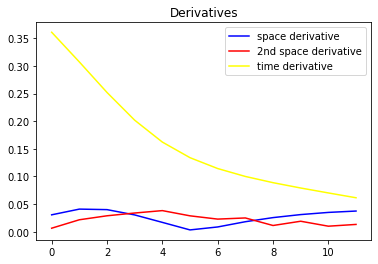

11th Epoch:
traing loss is 89.54132080078125, test loss is 89.56961822509766, and learning rate is 0.009999999776482582, elapsed is 2.141505241394043.
 
21th Epoch:
traing loss is 20.807912826538086, test loss is 20.809200286865234, and learning rate is 0.009999999776482582, elapsed is 0.3808128833770752.
 
31th Epoch:
traing loss is 4.761470794677734, test loss is 4.759542942047119, and learning rate is 0.009999999776482582, elapsed is 0.3891751766204834.
 
41th Epoch:
traing loss is 2.8415582180023193, test loss is 2.834280014038086, and learning rate is 0.009999999776482582, elapsed is 0.3847489356994629.
 
51th Epoch:
traing loss is 5.097737789154053, test loss is 5.133605003356934, and learning rate is 0.009999999776482582, elapsed is 0.7865872383117676.
 
61th Epoch:
traing loss is 0.3190584182739258, test loss is 0.32360365986824036, and learning rate is 0.009999999776482582, elapsed is 0.37266993522644043.
 
71th Epoch:
traing loss is 1.310706377029419, test loss is 1.311973571

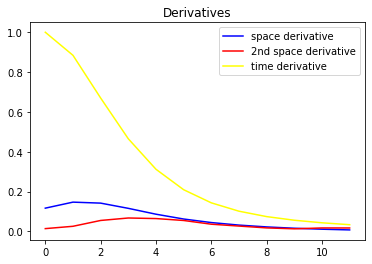

the space_derivative is 0.007790412288159132, the space_2nd_derivative is 0.013212171383202076
the policy_mean_tmp is [-0.02953617  0.06280334 -0.07455336 -0.03405302  0.0250843  -0.01760636
  0.0360334  -0.04083283 -0.08257856 -0.03531009 -0.02317918  0.00834985
  0.07718386  0.13381414 -0.1036598   0.00096869  0.03622116 -0.03308335
  0.03187482  0.07846762 -0.10431246  0.05736744 -0.0563775  -0.03343341
  0.01433417], 
 the policy_var_tmp is [[ 3.54733485e-01  6.24885435e-02 -2.47952895e-02 -3.45109815e-02
  -1.91894544e-02 -4.23061918e-02 -3.67399670e-02 -7.17252917e-03
  -1.14600972e-01 -4.47730323e-02  3.40514855e-02 -3.59112635e-02
   3.32359213e-02 -3.77260090e-02  6.58909809e-02 -2.47507170e-02
  -7.62600428e-02  7.07099140e-02 -4.31936275e-02 -9.16592140e-03
  -7.39879812e-02  2.28008765e-02  3.07238189e-02  4.11569730e-02
  -1.71191738e-02]
 [ 6.24885435e-02  1.59011373e-01  6.15199025e-03 -3.01634646e-02
  -2.55500953e-02  1.21986021e-03 -1.13941759e-03 -9.59653727e-03
  -4

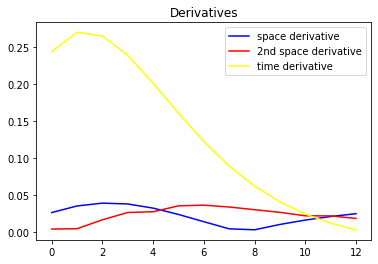

11th Epoch:
traing loss is 11.592726707458496, test loss is 11.659075736999512, and learning rate is 0.009999999776482582, elapsed is 3.029538154602051.
 
21th Epoch:
traing loss is 0.4200446605682373, test loss is 0.4308651387691498, and learning rate is 0.009999999776482582, elapsed is 0.5815219879150391.
 
31th Epoch:
traing loss is 0.23867341876029968, test loss is 0.23079803586006165, and learning rate is 0.009999999776482582, elapsed is 0.6009321212768555.
 
41th Epoch:
traing loss is 0.48964715003967285, test loss is 0.5042850971221924, and learning rate is 0.009999999776482582, elapsed is 0.4541463851928711.
 
51th Epoch:
traing loss is 0.10567417740821838, test loss is 0.1052546352148056, and learning rate is 0.009999999776482582, elapsed is 0.4119729995727539.
 
61th Epoch:
traing loss is 0.24029678106307983, test loss is 0.25226399302482605, and learning rate is 0.009999999776482582, elapsed is 0.4040839672088623.
 
71th Epoch:
traing loss is 0.14791683852672577, test loss i

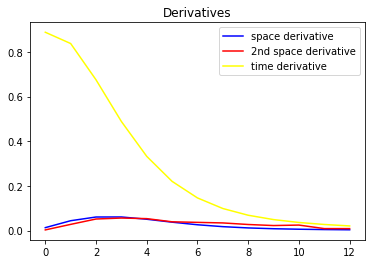

the space_derivative is 0.003635919187217951, the space_2nd_derivative is 0.015547915361821651
the policy_mean_tmp is [-0.01160627  0.02605577 -0.024999   -0.01312931  0.02102493 -0.00447736
  0.01490655 -0.01196831 -0.03272121 -0.01112883 -0.01016338  0.00285884
  0.02598443  0.05264571 -0.0419785  -0.00600509  0.01000956 -0.01391119
  0.0155532   0.02613417 -0.04160601  0.02509446 -0.02156471 -0.01456554
  0.00646773], 
 the policy_var_tmp is [[ 3.16635177e-01  5.99013791e-02 -1.75509316e-02 -2.75487532e-02
  -4.42650862e-03 -4.00195345e-02 -3.45246473e-02 -3.83805278e-03
  -1.04745598e-01 -3.93548117e-02  3.28462201e-02 -3.37521090e-02
   2.49319506e-02 -5.60328117e-02  7.62636382e-02 -2.69585036e-02
  -7.05785706e-02  8.42488636e-02 -3.46446546e-02 -1.93702147e-02
  -6.36728619e-02  1.99703908e-02  3.03189563e-02  3.09567269e-02
  -1.96376747e-02]
 [ 5.99013791e-02  1.37601999e-01  4.46723385e-03 -2.50232434e-02
  -2.20445164e-02 -2.08739905e-03 -2.77567363e-03 -9.30879374e-03
  -4

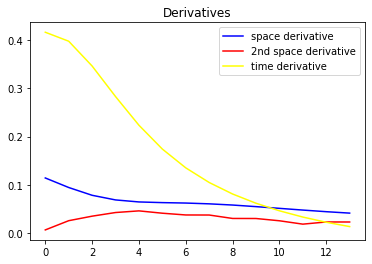

11th Epoch:
traing loss is 193.85781860351562, test loss is 193.77951049804688, and learning rate is 0.009999999776482582, elapsed is 2.8238260746002197.
 
21th Epoch:
traing loss is 2.4975669384002686, test loss is 2.5106918811798096, and learning rate is 0.009999999776482582, elapsed is 0.5265364646911621.
 
31th Epoch:
traing loss is 3.292776107788086, test loss is 3.2757599353790283, and learning rate is 0.009999999776482582, elapsed is 0.6389532089233398.
 
41th Epoch:
traing loss is 1.979086995124817, test loss is 1.9732738733291626, and learning rate is 0.009999999776482582, elapsed is 0.6385910511016846.
 
51th Epoch:
traing loss is 2.8371098041534424, test loss is 2.878526449203491, and learning rate is 0.009999999776482582, elapsed is 0.6140391826629639.
 
61th Epoch:
traing loss is 4.381674289703369, test loss is 4.381407737731934, and learning rate is 0.009999999776482582, elapsed is 0.6239354610443115.
 
71th Epoch:
traing loss is 0.3713679909706116, test loss is 0.3669911

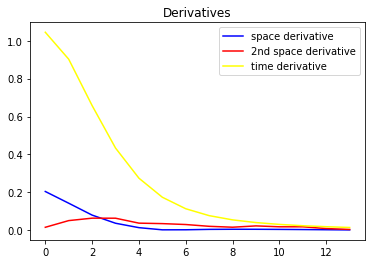

the space_derivative is 0.0019575958140194416, the space_2nd_derivative is 0.004555933643132448
the policy_mean_tmp is [-0.00402044  0.05476643 -0.03855186 -0.02277144  0.04086488 -0.0151885
  0.02224926 -0.01872596 -0.06274149 -0.02545816 -0.01464173  0.00211516
  0.04892547  0.06645102 -0.06374042 -0.01708312  0.00389843  0.00584405
  0.02688353  0.03925161 -0.0780367   0.04522836 -0.03533464 -0.02480524
  0.01807029], 
 the policy_var_tmp is [[ 1.15456309e+00  2.65829511e-01 -1.30147829e-01 -1.32455386e-01
   2.28553685e-02 -7.42202148e-02 -1.32957952e-01 -8.08354269e-02
  -3.19108074e-01 -2.74984621e-01  7.02899767e-02 -1.30359601e-01
   5.67122496e-02 -2.16481089e-01  1.99735511e-01 -1.72993292e-02
  -2.00865369e-01  2.91193752e-01 -1.18091567e-01 -3.17637526e-02
  -1.33122691e-01  1.36755225e-01  8.42884498e-02  1.77266702e-01
  -6.63046331e-02]
 [ 2.65829511e-01  5.12449819e-01 -1.72307442e-02 -1.06080205e-01
  -5.09331182e-02  2.12557493e-02 -2.37698006e-02 -6.72597976e-02
  -1

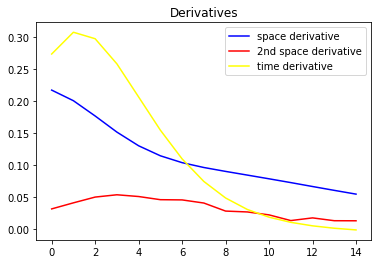

11th Epoch:
traing loss is 6.60575532913208, test loss is 6.635436058044434, and learning rate is 0.009999999776482582, elapsed is 3.2996621131896973.
 
21th Epoch:
traing loss is 1.8925237655639648, test loss is 1.9031152725219727, and learning rate is 0.009999999776482582, elapsed is 0.6624443531036377.
 
31th Epoch:
traing loss is 5.888846397399902, test loss is 5.903968334197998, and learning rate is 0.009999999776482582, elapsed is 0.6408357620239258.
 
41th Epoch:
traing loss is 1.038535475730896, test loss is 1.052356243133545, and learning rate is 0.009999999776482582, elapsed is 0.6513679027557373.
 
51th Epoch:
traing loss is 1.1050441265106201, test loss is 1.0899497270584106, and learning rate is 0.009999999776482582, elapsed is 0.45459651947021484.
 
61th Epoch:
traing loss is 0.06765156984329224, test loss is 0.07186811417341232, and learning rate is 0.009999999776482582, elapsed is 0.4556121826171875.
 
71th Epoch:
traing loss is 3.7940263748168945, test loss is 3.811653

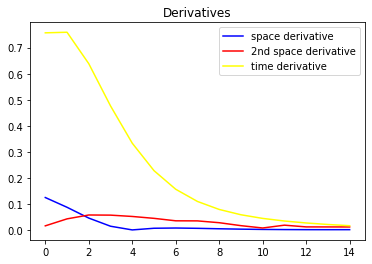

the space_derivative is 0.002337753539904952, the space_2nd_derivative is 0.012715748511254787
the policy_mean_tmp is [-0.00258094  0.01537778 -0.01661419 -0.00408819  0.01102394 -0.01290306
  0.00474496  0.00561659 -0.03085422 -0.0039154   0.00338651  0.00112929
  0.01752995  0.02271686 -0.01328321  0.00120976  0.00244385 -0.00317259
  0.00871864  0.01744106 -0.03450809  0.01012023 -0.01459561 -0.00716414
 -0.00270408], 
 the policy_var_tmp is [[ 4.14475436e-01  9.65253315e-02 -4.40972692e-02 -4.75358696e-02
   7.37380717e-03 -2.72277013e-02 -4.87521909e-02 -2.59140556e-02
  -1.15610636e-01 -1.01753231e-01  2.60018260e-02 -4.72598505e-02
   2.21886948e-02 -8.33463030e-02  7.52244563e-02 -7.45457461e-03
  -7.25775886e-02  1.10059205e-01 -4.19260239e-02 -1.36475679e-02
  -4.58839719e-02  4.82308350e-02  2.99412390e-02  6.27682577e-02
  -2.49693398e-02]
 [ 9.65253315e-02  1.77534434e-01  9.86064070e-04 -3.13780089e-02
  -2.84309939e-02 -1.97962751e-03 -1.75182432e-02  1.21213402e-03
  -5

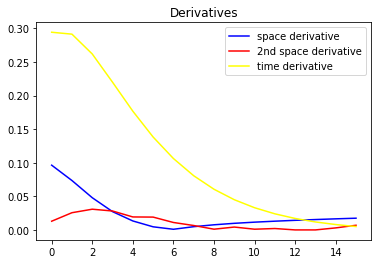

11th Epoch:
traing loss is 20.224872589111328, test loss is 20.331584930419922, and learning rate is 0.009999999776482582, elapsed is 3.1923770904541016.
 
21th Epoch:
traing loss is 9.840569496154785, test loss is 9.9015531539917, and learning rate is 0.009999999776482582, elapsed is 0.485093355178833.
 
31th Epoch:
traing loss is 9.933643341064453, test loss is 9.988980293273926, and learning rate is 0.009999999776482582, elapsed is 0.4920971393585205.
 
41th Epoch:
traing loss is 10.68704605102539, test loss is 10.771780967712402, and learning rate is 0.009999999776482582, elapsed is 0.4707915782928467.
 
51th Epoch:
traing loss is 0.9888299107551575, test loss is 0.994651198387146, and learning rate is 0.009999999776482582, elapsed is 0.480663537979126.
 
61th Epoch:
traing loss is 0.017995690926909447, test loss is 0.020738568156957626, and learning rate is 0.009999999776482582, elapsed is 0.4787595272064209.
 
71th Epoch:
traing loss is 0.04158854857087135, test loss is 0.0373106

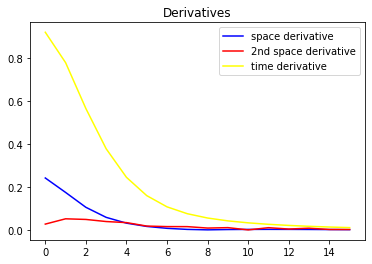

the space_derivative is 0.0012874146923422813, the space_2nd_derivative is 0.007988272234797478
the policy_mean_tmp is [ 0.0022678   0.01618442 -0.01901949 -0.00393676  0.00525768 -0.01253331
  0.00439317 -0.00426419 -0.02994498 -0.00611205  0.00270385  0.00119199
  0.01368715  0.02614716 -0.00927541  0.00206783  0.00060241 -0.00123075
  0.0073784   0.01513292 -0.03098281  0.01390327 -0.00710572 -0.00988265
 -0.00385646], 
 the policy_var_tmp is [[ 6.74711516e-01  1.66221996e-01 -7.04937797e-02 -7.92608164e-02
  -3.09643023e-03 -5.41601415e-02 -8.27821946e-02 -4.18938100e-02
  -2.01824379e-01 -1.78495973e-01  4.47961138e-02 -7.62855298e-02
   3.95858559e-02 -1.27489951e-01  1.31285052e-01 -1.68965318e-02
  -1.23713887e-01  1.91988137e-01 -6.94471830e-02 -2.71421420e-02
  -8.07916732e-02  9.02556325e-02  6.87725180e-02  8.61214461e-02
  -5.52648802e-02]
 [ 1.66221996e-01  2.91631468e-01 -4.76896318e-03 -5.19433231e-02
  -5.76081215e-02 -9.38274430e-03 -2.97264767e-02 -1.11529823e-02
  -

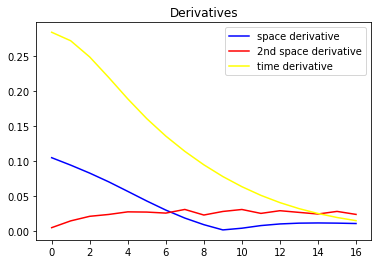

11th Epoch:
traing loss is 12.954546928405762, test loss is 12.96617317199707, and learning rate is 0.009999999776482582, elapsed is 4.126691818237305.
 
21th Epoch:
traing loss is 0.7083210945129395, test loss is 0.7068833112716675, and learning rate is 0.009999999776482582, elapsed is 0.7284419536590576.
 
31th Epoch:
traing loss is 0.14732731878757477, test loss is 0.14723823964595795, and learning rate is 0.009999999776482582, elapsed is 0.6212999820709229.
 
41th Epoch:
traing loss is 0.3598703444004059, test loss is 0.3628135025501251, and learning rate is 0.009999999776482582, elapsed is 0.5279519557952881.
 
51th Epoch:
traing loss is 0.1379237025976181, test loss is 0.14697636663913727, and learning rate is 0.009999999776482582, elapsed is 0.507042646408081.
 
61th Epoch:
traing loss is 0.3710816204547882, test loss is 0.37717658281326294, and learning rate is 0.009999999776482582, elapsed is 0.5042867660522461.
 
71th Epoch:
traing loss is 0.08963332325220108, test loss is 0.

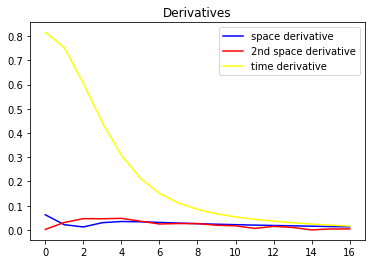

the space_derivative is 0.01276671513915062, the space_2nd_derivative is 0.01393545139580965
the policy_mean_tmp is [ 0.04152809  0.09809917 -0.10325858 -0.02338548  0.01841868 -0.07877293
  0.01985703 -0.01777118 -0.18639629 -0.05082851  0.02033164  0.00570931
  0.08965375  0.13107873 -0.03842797  0.0181637   0.00452731  0.02190654
  0.0360037   0.06385482 -0.19067605  0.07482855 -0.02472244 -0.04140634
 -0.02635051], 
 the policy_var_tmp is [[ 4.23288888e-01  1.09371524e-01 -5.66586596e-02 -5.05539486e-02
  -8.90624531e-03 -2.61284569e-02 -4.81071818e-02 -2.21538657e-02
  -1.35335471e-01 -1.18274560e-01  2.53499583e-02 -4.73536693e-02
   9.45648052e-03 -6.39083648e-02  7.65610240e-02 -1.45410142e-02
  -7.90860187e-02  1.18113820e-01 -4.04636085e-02 -2.69920387e-02
  -5.97882498e-02  6.37503256e-02  4.90531911e-02  7.06096645e-02
  -3.96670226e-02]
 [ 1.09371524e-01  1.71788382e-01 -6.08955277e-03 -3.12526809e-02
  -3.67461006e-02 -5.36506593e-03 -1.80540535e-02 -4.84652227e-03
  -6.6

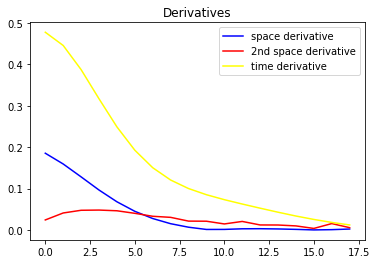

11th Epoch:
traing loss is 6.743369102478027, test loss is 6.727038383483887, and learning rate is 0.009999999776482582, elapsed is 4.463151216506958.
 
21th Epoch:
traing loss is 4.146530628204346, test loss is 4.141681671142578, and learning rate is 0.009999999776482582, elapsed is 0.8020391464233398.
 
31th Epoch:
traing loss is 1.1436982154846191, test loss is 1.1426951885223389, and learning rate is 0.009999999776482582, elapsed is 0.6908795833587646.
 
41th Epoch:
traing loss is 2.3892147541046143, test loss is 2.402405261993408, and learning rate is 0.009999999776482582, elapsed is 0.5401067733764648.
 
51th Epoch:
traing loss is 13.613844871520996, test loss is 13.531989097595215, and learning rate is 0.009999999776482582, elapsed is 0.5465652942657471.
 
61th Epoch:
traing loss is 2.481672525405884, test loss is 2.504631996154785, and learning rate is 0.009999999776482582, elapsed is 0.5530786514282227.
 
71th Epoch:
traing loss is 0.15350259840488434, test loss is 0.152084559

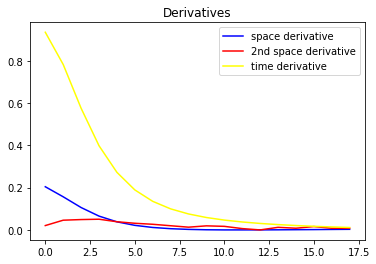

the space_derivative is 0.0028843784239143133, the space_2nd_derivative is 0.0
18
this is the length of x
0.0059791507056136
0.00027198819223181854
1th Epoch:
traing loss is 98.49151611328125, test loss is 98.63987731933594, and learning rate is 0.009999999776482582, elapsed is 10.099916934967041.
 


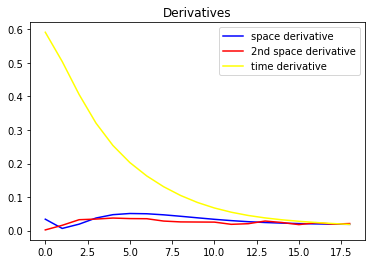

11th Epoch:
traing loss is 6.900660037994385, test loss is 6.8605523109436035, and learning rate is 0.009999999776482582, elapsed is 4.646493434906006.
 
21th Epoch:
traing loss is 1.3731207847595215, test loss is 1.3599350452423096, and learning rate is 0.009999999776482582, elapsed is 0.5480611324310303.
 
31th Epoch:
traing loss is 9.18651294708252, test loss is 9.156682014465332, and learning rate is 0.009999999776482582, elapsed is 0.5583465099334717.
 
41th Epoch:
traing loss is 0.03923056647181511, test loss is 0.036754779517650604, and learning rate is 0.009999999776482582, elapsed is 0.5578927993774414.
 
51th Epoch:
traing loss is 8.596552848815918, test loss is 8.560588836669922, and learning rate is 0.009999999776482582, elapsed is 0.5792644023895264.
 
61th Epoch:
traing loss is 1.6309870481491089, test loss is 1.6614596843719482, and learning rate is 0.009999999776482582, elapsed is 0.5549499988555908.
 
71th Epoch:
traing loss is 1.8808914422988892, test loss is 1.863806

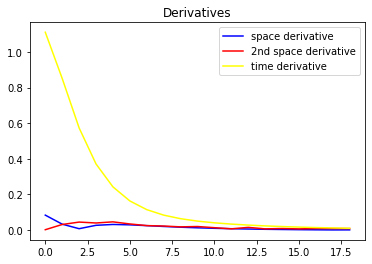

the space_derivative is 0.0003659286012407392, the space_2nd_derivative is 0.003886733902618289
the policy_mean_tmp is [ 0.00175385  0.00307831 -0.00885045  0.00027975  0.00683522 -0.0088833
  0.00268494 -0.00200843 -0.014713   -0.0058549   0.00353298  0.00031325
  0.00985126  0.01194914 -0.0009202   0.00783082  0.00080999  0.00319078
  0.00254312  0.00511155 -0.01654993 -0.00015191 -0.00589376 -0.0048528
  0.00044912], 
 the policy_var_tmp is [[ 1.56275068e+00  3.67554490e-01 -2.04622571e-01 -1.78569534e-01
  -1.26404650e-02 -7.71412344e-02 -2.03551038e-01 -7.74319778e-02
  -4.79737155e-01 -4.17641347e-01  7.30673138e-02 -1.62960280e-01
   2.85637754e-02 -1.92916155e-01  2.86006049e-01 -3.70915401e-02
  -2.89427346e-01  4.09763266e-01 -1.60898976e-01 -1.16042642e-01
  -1.97189959e-01  1.89080957e-01  1.71772420e-01  2.95136005e-01
  -1.33202437e-01]
 [ 3.67554490e-01  5.15519402e-01  1.78541267e-02 -8.12264882e-02
  -5.66753103e-02 -4.07617446e-04 -8.67073836e-02 -3.12603793e-02
  -1.

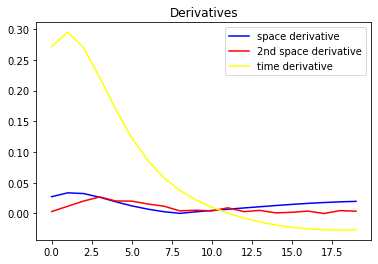

11th Epoch:
traing loss is 7.696861743927002, test loss is 7.709054470062256, and learning rate is 0.009999999776482582, elapsed is 5.057863473892212.
 
21th Epoch:
traing loss is 11.254947662353516, test loss is 11.2826566696167, and learning rate is 0.009999999776482582, elapsed is 0.9203155040740967.
 
31th Epoch:
traing loss is 0.5449350476264954, test loss is 0.552070140838623, and learning rate is 0.009999999776482582, elapsed is 0.8109943866729736.
 
41th Epoch:
traing loss is 6.5616774559021, test loss is 6.568094730377197, and learning rate is 0.009999999776482582, elapsed is 0.6239573955535889.
 
51th Epoch:
traing loss is 0.05798136070370674, test loss is 0.06606851518154144, and learning rate is 0.009999999776482582, elapsed is 0.6212399005889893.
 
61th Epoch:
traing loss is 5.223865985870361, test loss is 5.232919216156006, and learning rate is 0.009999999776482582, elapsed is 0.646235466003418.
 
71th Epoch:
traing loss is 0.15607815980911255, test loss is 0.153522372245

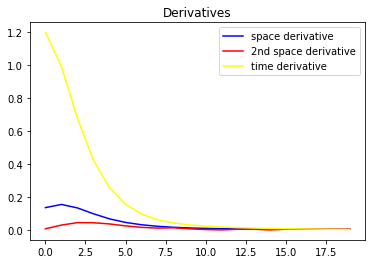

the space_derivative is 0.004331142175942659, the space_2nd_derivative is 0.003781242063269019
the policy_mean_tmp is [ 0.02600963  0.01969332 -0.11873753 -0.00032951  0.08118384 -0.11976749
  0.05403035 -0.04320377 -0.18352725 -0.06211998  0.05384867  0.00751976
  0.1352937   0.15631277  0.01506174  0.08562756 -0.00589922  0.04238458
  0.02818945  0.10586574 -0.21050249 -0.0164807  -0.07594242 -0.07201273
  0.00540581], 
 the policy_var_tmp is [[ 1.60138038e+00  3.61442507e-01 -2.13370842e-01 -1.86239241e-01
  -1.37015049e-02 -8.28096451e-02 -1.97814419e-01 -8.09735485e-02
  -5.03474503e-01 -4.19254682e-01  7.64007643e-02 -1.64030390e-01
   3.65227468e-02 -1.77394197e-01  3.03877276e-01 -4.67178358e-02
  -3.05562718e-01  4.09229294e-01 -1.64369832e-01 -9.92745374e-02
  -2.09437383e-01  1.86158415e-01  1.80299225e-01  2.90337850e-01
  -1.34948767e-01]
 [ 3.61442507e-01  5.21291548e-01  2.73612729e-02 -8.37907726e-02
  -5.69805673e-02  8.49373964e-03 -9.53902192e-02 -9.25923287e-03
  -1

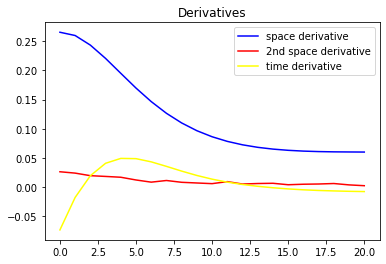

11th Epoch:
traing loss is 136.0073699951172, test loss is 136.10086059570312, and learning rate is 0.009999999776482582, elapsed is 5.210718631744385.
 
21th Epoch:
traing loss is 6.016000747680664, test loss is 6.025134086608887, and learning rate is 0.009999999776482582, elapsed is 0.9080004692077637.
 
31th Epoch:
traing loss is 0.7505802512168884, test loss is 0.751882791519165, and learning rate is 0.009999999776482582, elapsed is 0.9191131591796875.
 
41th Epoch:
traing loss is 1.3656173944473267, test loss is 1.3539342880249023, and learning rate is 0.009999999776482582, elapsed is 0.6465516090393066.
 
51th Epoch:
traing loss is 1.6123923063278198, test loss is 1.5856472253799438, and learning rate is 0.009999999776482582, elapsed is 0.6816530227661133.
 
61th Epoch:
traing loss is 0.01274988241493702, test loss is 0.010381846688687801, and learning rate is 0.009999999776482582, elapsed is 0.6672027111053467.
 
71th Epoch:
traing loss is 0.006701580714434385, test loss is 0.00

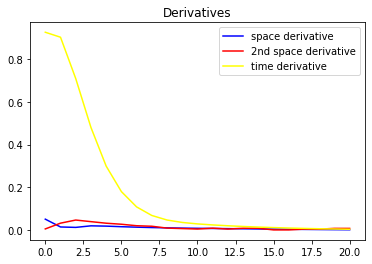

the space_derivative is 0.0006648116395808756, the space_2nd_derivative is 0.0036206552758812904
the policy_mean_tmp is [ 0.00253023  0.00290901 -0.01850889 -0.00161902  0.01102828 -0.02042596
  0.00956155 -0.00698945 -0.03012689 -0.0091962   0.01074969  0.00213763
  0.02132446  0.02671481  0.00217864  0.01036639 -0.00241592  0.00373313
  0.00156245  0.01745032 -0.03465397 -0.00086841 -0.01116945  0.00100783
 -0.00134682], 
 the policy_var_tmp is [[ 1.81056009e+00  3.94189420e-01 -3.64093881e-01 -2.36803351e-01
   9.15318687e-03 -9.16822793e-02 -2.01687688e-01 -1.22889376e-01
  -5.56431085e-01 -4.46551233e-01  7.74599486e-02 -1.70957279e-01
   4.16046075e-02 -1.55389425e-01  3.36617710e-01 -4.89917746e-02
  -3.13268978e-01  4.22918789e-01 -1.64904165e-01 -5.48916967e-02
  -2.31655511e-01  2.32538425e-01  1.78188571e-01  3.03851844e-01
  -1.39972983e-01]
 [ 3.94189420e-01  5.46428409e-01  1.13324163e-02 -9.28966243e-02
  -5.68926839e-02  8.07251397e-03 -9.89025746e-02 -1.43748772e-02
  

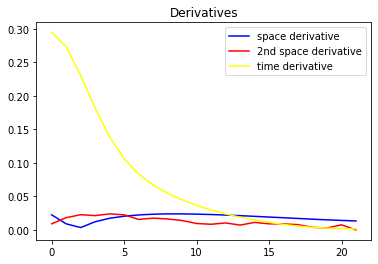

11th Epoch:
traing loss is 5.871718883514404, test loss is 5.831589698791504, and learning rate is 0.009999999776482582, elapsed is 6.164474010467529.
 
21th Epoch:
traing loss is 11.182321548461914, test loss is 11.142111778259277, and learning rate is 0.009999999776482582, elapsed is 0.6711616516113281.
 
31th Epoch:
traing loss is 0.7037409543991089, test loss is 0.6947250366210938, and learning rate is 0.009999999776482582, elapsed is 0.6693060398101807.
 
41th Epoch:
traing loss is 1.7728191614151, test loss is 1.7479766607284546, and learning rate is 0.009999999776482582, elapsed is 0.6787145137786865.
 
51th Epoch:
traing loss is 4.805737018585205, test loss is 4.841416835784912, and learning rate is 0.009999999776482582, elapsed is 0.6777997016906738.
 
61th Epoch:
traing loss is 1.4749583005905151, test loss is 1.5060744285583496, and learning rate is 0.009999999776482582, elapsed is 0.676781177520752.
 
71th Epoch:
traing loss is 4.210162162780762, test loss is 4.237409114837

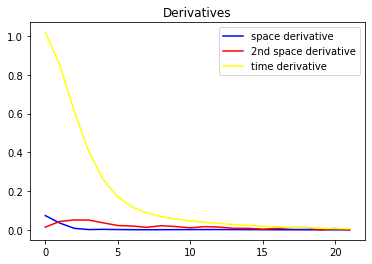

the space_derivative is 0.0005108239711262286, the space_2nd_derivative is 0.0
22
this is the length of x
0.005461823815871136
0.00027935841860756816
1th Epoch:
traing loss is 1290.6217041015625, test loss is 1291.1939697265625, and learning rate is 0.009999999776482582, elapsed is 14.451993703842163.
 


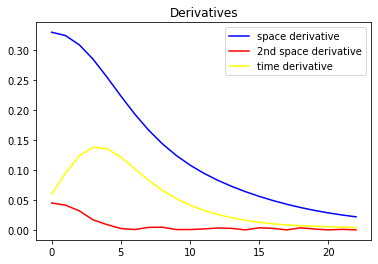

11th Epoch:
traing loss is 86.1804428100586, test loss is 86.33452606201172, and learning rate is 0.009999999776482582, elapsed is 6.649318695068359.
 
21th Epoch:
traing loss is 0.47660884261131287, test loss is 0.48381975293159485, and learning rate is 0.009999999776482582, elapsed is 0.6947734355926514.
 
31th Epoch:
traing loss is 5.890934467315674, test loss is 5.914236068725586, and learning rate is 0.009999999776482582, elapsed is 0.6902134418487549.
 
41th Epoch:
traing loss is 0.22266128659248352, test loss is 0.2135133147239685, and learning rate is 0.009999999776482582, elapsed is 0.6971054077148438.
 
51th Epoch:
traing loss is 0.015231217257678509, test loss is 0.016291692852973938, and learning rate is 0.009999999776482582, elapsed is 0.7005875110626221.
 
61th Epoch:
traing loss is 0.816900372505188, test loss is 0.7916737794876099, and learning rate is 0.009999999776482582, elapsed is 0.7154679298400879.
 
71th Epoch:
traing loss is 2.7207415103912354, test loss is 2.69

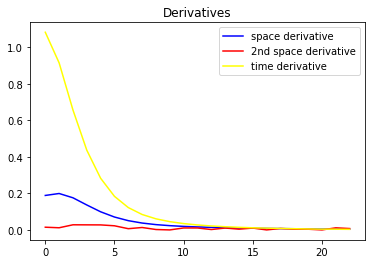

the space_derivative is 0.0041291601955890656, the space_2nd_derivative is 0.003800230333581567
the policy_mean_tmp is [ 0.06559935  0.03156349 -0.09495075 -0.00831079  0.06535882 -0.11830597
  0.04494778 -0.04679703 -0.20186259 -0.06631156  0.06282391  0.00539979
  0.10164891  0.13449723  0.02311148  0.06155057 -0.02523167  0.08706252
  0.01581509  0.0380204  -0.20993434 -0.00221371 -0.04966562  0.0281144
 -0.01071707], 
 the policy_var_tmp is [[ 1.60389531e+00  3.60853387e-01 -2.89700579e-01 -2.22915365e-01
  -1.37058108e-02 -9.44501855e-02 -1.43193218e-01 -1.45625866e-01
  -4.83062354e-01 -3.80726753e-01  6.65361428e-02 -1.54597422e-01
   6.40855528e-02 -3.08577005e-02  3.16487794e-01 -9.20657427e-02
  -2.98727079e-01  2.87485827e-01 -1.44742447e-01 -3.37486538e-02
  -2.20124167e-01  2.21305164e-01  9.95927960e-02  2.73950072e-01
  -8.73770090e-02]
 [ 3.60853387e-01  5.34174014e-01  3.86611863e-02 -9.97381330e-02
  -9.97045841e-02  1.47697878e-02 -8.10052257e-02 -1.26327925e-02
  -1

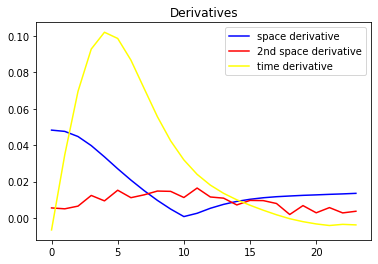

11th Epoch:
traing loss is 123.89984893798828, test loss is 123.86644744873047, and learning rate is 0.009999999776482582, elapsed is 6.7992212772369385.
 
21th Epoch:
traing loss is 0.4720006585121155, test loss is 0.46635791659355164, and learning rate is 0.009999999776482582, elapsed is 0.7117040157318115.
 
31th Epoch:
traing loss is 8.131136894226074, test loss is 8.103981971740723, and learning rate is 0.009999999776482582, elapsed is 0.7123456001281738.
 
41th Epoch:
traing loss is 0.607860803604126, test loss is 0.6073267459869385, and learning rate is 0.009999999776482582, elapsed is 0.7256639003753662.
 
51th Epoch:
traing loss is 0.5189028978347778, test loss is 0.4943186342716217, and learning rate is 0.009999999776482582, elapsed is 0.7313077449798584.
 
61th Epoch:
traing loss is 0.03329215571284294, test loss is 0.03321949020028114, and learning rate is 0.009999999776482582, elapsed is 0.7159347534179688.
 
71th Epoch:
traing loss is 0.4888678193092346, test loss is 0.48

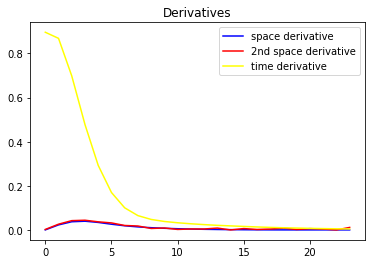

the space_derivative is 0.00017035726341418922, the space_2nd_derivative is 0.0
24
this is the length of x
0.004984036071777183
0.0002577411690074458
1th Epoch:
traing loss is 2262.63134765625, test loss is 2263.29248046875, and learning rate is 0.009999999776482582, elapsed is 14.392773866653442.
 


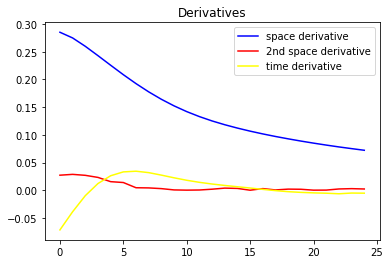

11th Epoch:
traing loss is 0.5468463897705078, test loss is 0.5363956093788147, and learning rate is 0.009999999776482582, elapsed is 6.414163827896118.
 
21th Epoch:
traing loss is 4.121143817901611, test loss is 4.140940189361572, and learning rate is 0.009999999776482582, elapsed is 0.7358636856079102.
 
31th Epoch:
traing loss is 0.146418496966362, test loss is 0.1429508924484253, and learning rate is 0.009999999776482582, elapsed is 0.7441766262054443.
 
41th Epoch:
traing loss is 0.5944867730140686, test loss is 0.6075093150138855, and learning rate is 0.009999999776482582, elapsed is 0.7494454383850098.
 
51th Epoch:
traing loss is 7.550462245941162, test loss is 7.596353530883789, and learning rate is 0.009999999776482582, elapsed is 0.7349655628204346.
 
61th Epoch:
traing loss is 2.4470481872558594, test loss is 2.4093267917633057, and learning rate is 0.009999999776482582, elapsed is 0.7174878120422363.
 
71th Epoch:
traing loss is 0.26369693875312805, test loss is 0.2694240

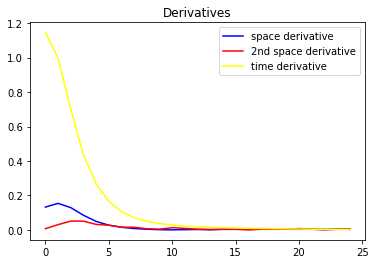

the space_derivative is 0.0037478599697351456, the space_2nd_derivative is 0.0
25
this is the length of x
0.004784674628906096
0.00024802108687457623
1th Epoch:
traing loss is 955.5494995117188, test loss is 955.4186401367188, and learning rate is 0.009999999776482582, elapsed is 15.48015546798706.
 


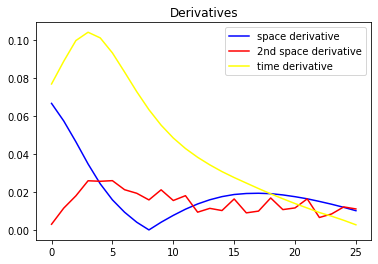

11th Epoch:
traing loss is 4.685318946838379, test loss is 4.692662239074707, and learning rate is 0.009999999776482582, elapsed is 7.467839479446411.
 
21th Epoch:
traing loss is 9.777291297912598, test loss is 9.801291465759277, and learning rate is 0.009999999776482582, elapsed is 0.7397234439849854.
 
31th Epoch:
traing loss is 0.5919479727745056, test loss is 0.5984615683555603, and learning rate is 0.009999999776482582, elapsed is 0.7275805473327637.
 
41th Epoch:
traing loss is 1.726291298866272, test loss is 1.7280082702636719, and learning rate is 0.009999999776482582, elapsed is 0.7544224262237549.
 
51th Epoch:
traing loss is 5.651688098907471, test loss is 5.732407569885254, and learning rate is 0.009999999776482582, elapsed is 0.7419314384460449.
 
61th Epoch:
traing loss is 0.34017106890678406, test loss is 0.33559858798980713, and learning rate is 0.009999999776482582, elapsed is 0.7834296226501465.
 
71th Epoch:
traing loss is 0.18523360788822174, test loss is 0.1874402

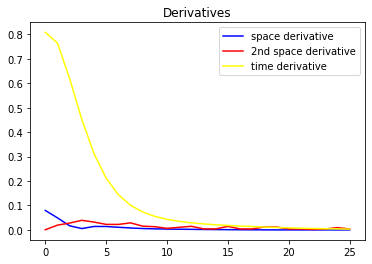

the space_derivative is 4.2589315853547305e-05, the space_2nd_derivative is 0.007607837673276663
the policy_mean_tmp is [ 4.87336830e-04  3.80469911e-04 -6.01660683e-04 -3.35672872e-04
  5.61676481e-04 -5.34006424e-04  3.20989751e-04 -4.08551221e-04
 -1.18094793e-03 -3.43591086e-04  3.72710663e-04 -6.82114466e-05
  4.62626431e-04  9.45488159e-05  3.92491578e-04  1.50424064e-04
 -3.07287279e-04  1.08015458e-03  4.11470401e-04  6.60752392e-04
 -1.06192497e-03  3.20135239e-05 -7.80486960e-04  4.36706332e-05
  4.49625771e-05], 
 the policy_var_tmp is [[ 7.25322000e-01  1.53331070e-01 -1.15703578e-01 -6.98134507e-02
   4.05812957e-02 -5.39339436e-02 -6.02371405e-02 -6.92714824e-02
  -2.19106353e-01 -1.56533602e-01  3.37706805e-02 -6.05279509e-02
   3.83032895e-02 -1.77703306e-02  1.12502445e-01  1.04244878e-02
  -1.00494361e-01  1.21299896e-01 -6.39232087e-02 -5.07173149e-02
  -9.81232771e-02  6.91482700e-02  5.38298359e-03  1.10172282e-01
  -1.54662240e-02]
 [ 1.53331070e-01  2.57437421e-0

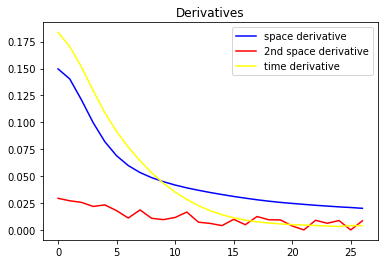

11th Epoch:
traing loss is 1.8950756788253784, test loss is 1.8710633516311646, and learning rate is 0.009999999776482582, elapsed is 7.856346845626831.
 
21th Epoch:
traing loss is 4.91382360458374, test loss is 4.938822269439697, and learning rate is 0.009999999776482582, elapsed is 0.8050436973571777.
 
31th Epoch:
traing loss is 16.8957462310791, test loss is 16.933277130126953, and learning rate is 0.009999999776482582, elapsed is 0.7734436988830566.
 
41th Epoch:
traing loss is 0.45789825916290283, test loss is 0.4445604979991913, and learning rate is 0.009999999776482582, elapsed is 0.7820720672607422.
 
51th Epoch:
traing loss is 1.74336838722229, test loss is 1.7143702507019043, and learning rate is 0.009999999776482582, elapsed is 0.8021214008331299.
 
61th Epoch:
traing loss is 1.5998077392578125, test loss is 1.6349855661392212, and learning rate is 0.009999999776482582, elapsed is 0.7682559490203857.
 
71th Epoch:
traing loss is 1.49660062789917, test loss is 1.51258647441

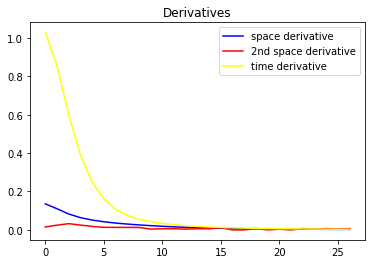

the space_derivative is 0.002814107807353139, the space_2nd_derivative is 0.006976590026170015
the policy_mean_tmp is [ 0.03466015  0.02831439 -0.04627893 -0.02002557  0.04256019 -0.03860002
  0.02459841 -0.03550689 -0.08264517 -0.0324798   0.02532986 -0.00501323
  0.04605582 -0.00497734  0.0449603   0.01333536 -0.03292513  0.09227343
  0.02684607  0.05771414 -0.07618443 -0.00382471 -0.04833256  0.01102915
  0.00312962], 
 the policy_var_tmp is [[ 7.90060036e-01  1.66374680e-01 -1.23900010e-01 -7.69520380e-02
   4.37423615e-02 -6.07256055e-02 -6.45916787e-02 -7.48082938e-02
  -2.40782694e-01 -1.62537467e-01  3.70968850e-02 -6.58160360e-02
   3.11178750e-02 -1.27180800e-02  1.15517324e-01  1.07881806e-02
  -1.04264146e-01  1.25014784e-01 -6.62211875e-02 -5.88416276e-02
  -1.11039476e-01  7.83314507e-02 -8.25386116e-05  1.15650743e-01
  -1.47359363e-02]
 [ 1.66374680e-01  2.80409424e-01  2.80513242e-02 -4.32145374e-02
  -2.74310637e-02  3.83788676e-03 -3.35381324e-02 -1.34996220e-02
  -9

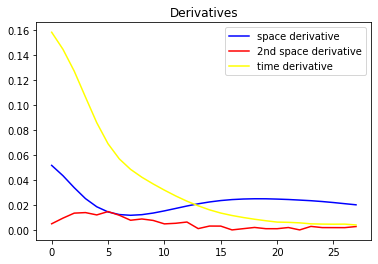

11th Epoch:
traing loss is 3.0303361415863037, test loss is 3.011989116668701, and learning rate is 0.009999999776482582, elapsed is 7.541121244430542.
 
21th Epoch:
traing loss is 0.5361737012863159, test loss is 0.5325533747673035, and learning rate is 0.009999999776482582, elapsed is 0.7901763916015625.
 
31th Epoch:
traing loss is 0.2138148993253708, test loss is 0.2142423838376999, and learning rate is 0.009999999776482582, elapsed is 0.7882373332977295.
 
41th Epoch:
traing loss is 0.2026454657316208, test loss is 0.1974845975637436, and learning rate is 0.009999999776482582, elapsed is 0.7847979068756104.
 
51th Epoch:
traing loss is 1.2230987548828125, test loss is 1.1884963512420654, and learning rate is 0.009999999776482582, elapsed is 0.7690238952636719.
 
61th Epoch:
traing loss is 1.0712896585464478, test loss is 1.094612956047058, and learning rate is 0.009999999776482582, elapsed is 1.0965631008148193.
 
71th Epoch:
traing loss is 1.5932186841964722, test loss is 1.58496

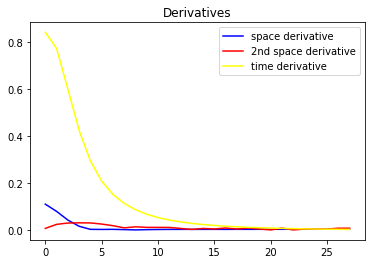

the space_derivative is 0.002896717516705394, the space_2nd_derivative is 0.01478441059589386
the policy_mean_tmp is [ 0.01742322  0.0136081  -0.02162838 -0.00987979  0.01872277 -0.01770459
  0.0103982  -0.0192392  -0.03960728 -0.01259742  0.01119474 -0.00301619
  0.01964209 -0.00533219  0.02233219  0.00631372 -0.01478445  0.04741885
  0.01443009  0.02987524 -0.03598878 -0.00098299 -0.02357808  0.0041272
  0.0007011 ], 
 the policy_var_tmp is [[ 3.73442492e-01  7.81381443e-02 -5.68776629e-02 -3.63557002e-02
   1.71703965e-02 -2.66784721e-02 -3.38032951e-02 -3.90415135e-02
  -1.11911451e-01 -7.05253584e-02  1.58960217e-02 -3.22695784e-02
   8.89951296e-03 -1.23426047e-02  5.53916697e-02  5.21517653e-03
  -4.59008102e-02  6.40416214e-02 -2.84427201e-02 -2.49944004e-02
  -4.99609615e-02  3.89655817e-02 -7.59967199e-04  5.16997967e-02
  -9.07077315e-03]
 [ 7.81381443e-02  1.32226648e-01  1.32883204e-02 -2.01937931e-02
  -1.29151474e-02  1.89630086e-03 -1.62878187e-02 -6.50813163e-03
  -4.2

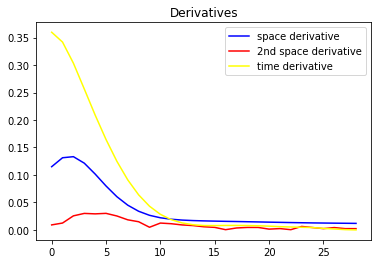

11th Epoch:
traing loss is 42.09824752807617, test loss is 42.016109466552734, and learning rate is 0.009999999776482582, elapsed is 8.679038763046265.
 
21th Epoch:
traing loss is 1.3183287382125854, test loss is 1.3396908044815063, and learning rate is 0.009999999776482582, elapsed is 0.8141701221466064.
 
31th Epoch:
traing loss is 0.02233107015490532, test loss is 0.01934167556464672, and learning rate is 0.009999999776482582, elapsed is 0.8250172138214111.
 
41th Epoch:
traing loss is 2.099299669265747, test loss is 2.086371660232544, and learning rate is 0.009999999776482582, elapsed is 0.81020188331604.
 
51th Epoch:
traing loss is 1.3673617839813232, test loss is 1.4344732761383057, and learning rate is 0.009999999776482582, elapsed is 0.8078103065490723.
 
61th Epoch:
traing loss is 0.024778936058282852, test loss is 0.023215273395180702, and learning rate is 0.009999999776482582, elapsed is 0.8110918998718262.
 
71th Epoch:
traing loss is 0.5360283851623535, test loss is 0.52

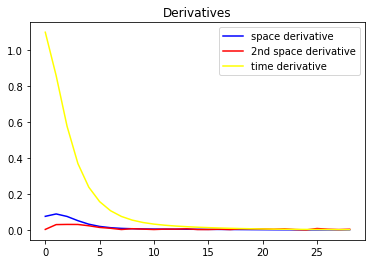

the space_derivative is 0.0004919559578411281, the space_2nd_derivative is 0.0
29
this is the length of x
0.003953733216821759
0.00032772757717420924
1th Epoch:
traing loss is 297.0063171386719, test loss is 297.0979919433594, and learning rate is 0.009999999776482582, elapsed is 19.077492475509644.
 


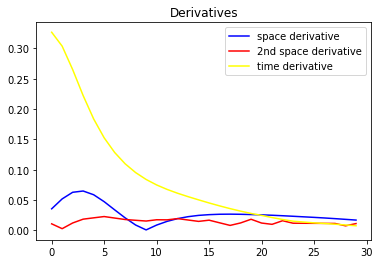

11th Epoch:
traing loss is 2.7872281074523926, test loss is 2.797011375427246, and learning rate is 0.009999999776482582, elapsed is 8.4856538772583.
 
21th Epoch:
traing loss is 7.319698333740234, test loss is 7.317995071411133, and learning rate is 0.009999999776482582, elapsed is 0.8759403228759766.
 
31th Epoch:
traing loss is 2.664141893386841, test loss is 2.6588473320007324, and learning rate is 0.009999999776482582, elapsed is 0.8379719257354736.
 
41th Epoch:
traing loss is 4.410035610198975, test loss is 4.390376091003418, and learning rate is 0.009999999776482582, elapsed is 0.8352336883544922.
 
51th Epoch:
traing loss is 2.0789129734039307, test loss is 2.0260140895843506, and learning rate is 0.009999999776482582, elapsed is 1.102430820465088.
 
61th Epoch:
traing loss is 4.098060607910156, test loss is 4.056703567504883, and learning rate is 0.009999999776482582, elapsed is 1.2312281131744385.
 
71th Epoch:
traing loss is 0.2511027455329895, test loss is 0.24922703206539

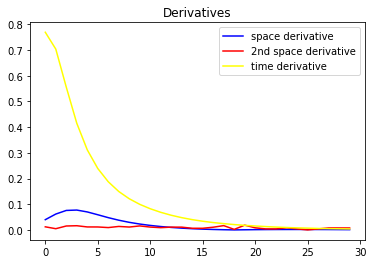

the space_derivative is 0.0010694694938138127, the space_2nd_derivative is 0.0


In [ ]:

for i in range(300, 300 + periods):
  A_tmp = A[i]
  B_tmp = B[i]

  z = (x[-1] - x[0]) / x[0]
  T = len(x)
  print(T)
  print('this is the length of x')
  dt = 1
  steps = int(T / dt)
  a = np.array([(x[j] - x[j - 1]) / x[j -1] for j in range(1, len(x))])
  sigma = a.var()
  print(z / T)
  print(sigma)



  sess = tf.Session()

  path = tf.placeholder(dtype=tf.float32, shape=[M,steps+1])
  time = tf.placeholder(dtype = tf.float32, shape = [M, steps +1 + 1])


  loss, solution, time_derivative, space_derivative, space_2nd_derivative = loss_function(time, path, M, A_tmp, B_tmp)
  global_step = tf.Variable(0, trainable=False)
  starter_learning_rate = 0.01
  learning_rate = tf.maximum(tf.train.exponential_decay(starter_learning_rate, global_step, 50, 0.98, staircase=True), tf.constant(0.00001))
  optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
  grads_and_vars = optimizer.compute_gradients(loss)
  capped_gvs = [(tf.clip_by_norm(grad, 1.), var) for grad, var in grads_and_vars]
  train_op = optimizer.apply_gradients(capped_gvs)

  init = tf.global_variables_initializer()
  sess.run(init)


  # GBM
  path_test = Create_paths(i, M, z, T, sigma, x_0)
  time_feed = generate_t(T, steps, M)
  pred_dict = {path: path_test, time: time_feed}

  train_loss_list = []
  test_loss_list = []

  start_time = ttt.time()

  for it in range(Epoch):
      seed = it % 100
      path_feed =  Create_paths(seed, M, z, T, sigma, x_0)
      feed_dict = {path: path_feed, time: time_feed}
      sess.run(train_op, feed_dict)

      if (it % 10 == 0): # every 10 epoch print and record
          elapsed = ttt.time() - start_time
          print("{}th Epoch:".format(it+1))
          loss_value = sess.run(loss, feed_dict)
          lr = sess.run(learning_rate)
          loss_test = sess.run(loss, pred_dict)
          print("traing loss is {}, test loss is {}, and learning rate is {}, elapsed is {}.".format(loss_value, loss_test, lr, elapsed))
          print(" ")

          train_loss_list.append(loss_value)
          test_loss_list.append(loss_test)        
          start_time = ttt.time()

          # plot the time and space derivatives.
      if (it % 100 == 0): # every 100 epoch, show picture

          solution_pred, time_derivative_pred, space_derivative_pred, space_2nd_derivative_pred = sess.run([solution, time_derivative, space_derivative, space_2nd_derivative], pred_dict)
          num_epoches = len(train_loss_list)
          x_axis_epoches = np.linspace(0, num_epoches*10, num_epoches)

          plt.plot(np.linspace(0,T, steps+1), space_derivative_pred[1], label = "space derivative", color = 'blue')
          plt.plot(np.linspace(0,T, steps+1), space_2nd_derivative_pred[1], label = "2nd space derivative", color = 'red')
          plt.plot(np.linspace(0,T, steps+1), time_derivative_pred[1], label = "time derivative", color = 'yellow')
          plt.legend()
          plt.title("Derivatives")
          plt.show()


  s_x = np.insert(x, 0, 1, axis = 0)
  new_x = np.tile(s_x, (M,1))
  pred_dict2 = {path: new_x, time: time_feed}
  solution_2, space_derivative_2, space_2nd_derivative_2, time_derivative_2 = sess.run([solution, space_derivative, space_2nd_derivative, time_derivative], pred_dict2)
  if space_2nd_derivative_2[0][-1] > 0:
    policy_mean_tmp = policy_mean[i] * (space_derivative_2[0][-1] / space_2nd_derivative_2[0][-1])
    policy_var_tmp = policy_variance[i] * (1 / space_2nd_derivative_2[0][-1])
    holdings = np.random.multivariate_normal(policy_mean_tmp, policy_var_tmp)
    print("the space_derivative is {}, the space_2nd_derivative is {}".format(space_derivative_2[0][-1], space_2nd_derivative_2[0][-1]))
    print("the policy_mean_tmp is {}, \n the policy_var_tmp is {}".format(policy_mean_tmp, policy_var_tmp))
    print('the holdings is {}'.format(holdings))
    #new_holdings = holdings / np.sum(holdings)
    profit = np.dot(holdings, ((stock_prices[i + 1] - stock_prices[i]) / stock_prices[i]))
    print('the profit is {}'.format(profit))
    new_wealth = profit + x[-1]
    x = np.append(x, new_wealth)

  else:
    x = np.append(x, x[-1])
    print("the space_derivative is {}, the space_2nd_derivative is {}".format(space_derivative_2[0][-1], space_2nd_derivative_2[0][-1]))

  sess.close()

  

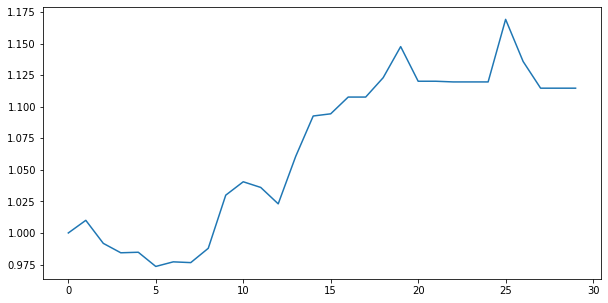

In [ ]:
plt.figure(figsize = (10,5))
plt.plot(x)
plt.show()

In [ ]:
print(x)

[1.         1.01       0.99175514 0.98429445 0.98472389 0.97347639
 0.97711832 0.97651257 0.98783647 1.02992725 1.0405395  1.03605545
 1.02304884 1.06065644 1.09263136 1.09435587 1.10762471 1.10762471
 1.12296913 1.14760244 1.12016012 1.12016012 1.11961687 1.11961687
 1.11961687 1.16917221 1.13582916 1.11465826 1.11465826 1.11465826]


In [ ]:

np.save('361-391-trading-days.npy', x)